In [43]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#import wrangle
import env
import seaborn as sns
import acquire
import prep
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
#single family residence from zillow DB
df = prep.prep_df()

In [ ]:
df.isnull().sum().sort_values(ascending=False)

In [ ]:
#drops columns with < 80% of values filled in
df = prep.impute_values(df)
df = prep.drop_columns(df)

In [ ]:
df = df.dropna(how='any')

In [ ]:
test = df[(df.propertycountylandusecode != "010G") & ((df.propertycountylandusecode != "010M"))]

test.propertycountylandusecode.astype(float)

In [ ]:
test = df[(df.propertycountylandusecode == "010G") | ((df.propertycountylandusecode == "010M"))]

test.shape

In [ ]:
df[['landtaxvaluedollarcnt','lotsizesquarefeet']].head()

In [ ]:
df['tax_value_per_foot'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet
df.tax_value_per_foot.mean()

In [ ]:
(df.structuretaxvaluedollarcnt/df.tax_value).mean()

In [ ]:
df.head().T

In [ ]:
df.lotsizesquarefeet.head()

In [ ]:
df.landtaxvaluedollarcnt /df.tax_value_per_foot.mean()

In [ ]:
df_nulls_r = pd.DataFrame(df.apply(lambda x: df.shape[1] -x.count(),axis=1))
df_nulls_r['pct_rows_missing'] = df_nulls_r[0] / df.shape[1]
row_drops = df_nulls_r[df_nulls_r['pct_rows_missing'] >.2]
row_drops['column_names'] = row_drops.index
row_drops = list(row_drops.column_names)
#df_new = df.drop(row_drops,axis=0)

df_nulls_r.max()


In [ ]:
Q1 = df.quantile(.25)
Q3 = df.quantile(.75)
IQR = Q3-Q1

In [ ]:
IQR = Q3-Q1
Q1

In [ ]:
df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
def outlier(series):
    Q1 = series.quantile(.25)
    Q3 = series.quantile(.75)
    IQR = Q3-Q1
    
    series = series[((series < (Q1 - 3 * IQR)) |(series > (Q3 + 3 * IQR)))]
    return series

In [ ]:
def remove_outliers_iqr(df, columns):
    for col in columns:
        q75, q25 = np.percentile(df[col], [75,25])
        ub = 3*stats.iqr(df[col]) + q75
        lb = q25 - 3*stats.iqr(df[col])
        print(len(df[df[col] <= ub]))
        df = df[df[col] <= ub]
        df = df[df[col] >= lb]
    return df

In [ ]:
len(remove_outliers_iqr(df,['tax_value','sqft','lotsizesquarefeet','structuretaxvaluedollarcnt']))

In [ ]:
df.shape

In [3]:
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import prep
import seaborn as sns
from sklearn.cluster import KMeans
 

In [4]:
train, test = train_test_split(df, train_size = .75, random_state = 123)

In [ ]:
train.head()

In [5]:
X_train = train.drop(columns=['logerror','fips','latitude','longitude','regionidcity','regionidcounty','regionidzip'])
y_train = train[['logerror']]
X_test = test.drop(columns=['logerror','fips','latitude','longitude','regionidcity','regionidcounty','regionidzip'])
y_test = test[['logerror']]
X_train.tax_value = X_train.tax_value /1000
X_train.structuretaxvaluedollarcnt = X_train.structuretaxvaluedollarcnt/1000

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_train)
kmeans.predict(X_train)
#X_train['cluster'] = kmeans.predict(X_train)

In [ ]:
pd.DataFrame(kmeans.cluster_centers_, columns=X_train.columns)\
    .reset_index()\
    .rename({'index': 'cluster'}, axis=1)\
    .set_index('cluster')

In [ ]:
X_train['cluster'] = kmeans.predict(X_train)
X_train.head()

In [ ]:
sns.pairplot(X_train,vars=['sqft','bedrooms','bathrooms','tax_value','lotsizesquarefeet'])

In [ ]:
X_train.describe()

In [ ]:
from sklearn.linear_model import LassoCV

reg = LassoCV()
reg.fit(X_train, y_train)

print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_train,y_train))
coef = pd.Series(reg.coef_, index = X_train.columns)


print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

In [ ]:
coef.sort_values()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
import warnings

In [ ]:
from sklearn.linear_model import LinearRegression

lm1 = LinearRegression()

print(lm1)

In [ ]:
lm1.fit(X_train, y_train)
print("Linear Model:", lm1)

lm1_y_intercept = lm1.intercept_
print("intercept: ", lm1_y_intercept)

lm1_coefficients = lm1.coef_
print("coefficients: ", lm1_coefficients)

In [ ]:
y_pred_lm1 = lm1.predict(X_train)

In [ ]:
train.describe()

In [ ]:
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(X_train['sqft','tax_value'])
    y_train['cluster'] = kmeans.predict(y_train)

In [6]:
def target_cluster(y_train,X_train):
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(y_train)
    y_train['cluster'] = kmeans.predict(y_train)
    train = X_train.merge(y_train,left_index=True,right_index=True)
    return train

In [8]:
train = target_cluster(y_train,X_train)

In [24]:
20300/8

2537.5

In [ ]:
y_train['cluster'] = kmeans.predict(y_train)


In [25]:
train.groupby('cluster').mean().sort_values(by='logerror')

,bathrooms,bedrooms,sqft,tax_value,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,logerror
cluster,,,,,,,,
4,2.236842,3.184211,1900.657895,530.876658,9861.578947,1956.210526,182.679276,-1.365637
0,2.213642,3.291158,1849.058173,443.084847,10560.522219,1960.540430,172.793398,-0.177691
2,2.249106,3.308673,1862.851617,455.815622,9960.799561,1961.015539,176.942214,0.014371
1,2.295260,3.336379,1900.987436,461.442537,9847.506027,1961.200457,188.270842,0.367658
3,2.229167,3.341667,1789.233333,379.317992,7550.738089,1958.075000,147.098533,1.872766


In [58]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#train = pd.DataFrame(scaler.fit_transform(train),columns=train.logerror)
scaled_logerror = df[['logerror']]
scaled_logerror['scaled_logerror'] = pd.DataFrame(scaler.fit_transform(scaled_logerror))
train = train.merge(scaled_logerror,left_index=True,right_index=True)

train.head()

,bathrooms,bedrooms,sqft,tax_value,lotsizesquarefeet,propertycountylandusecode,yearbuilt,structuretaxvaluedollarcnt,logerror_x,cluster,qcut,0_x,0_y,logerror_y,scaled_logerror
12854,2.0,3.0,1838.0,216.159,9796.0,0100,1999.0,172.934,0.051355,2,3,0.468572,0.468572,0.051355,0.468572
6103,2.0,3.0,2306.0,181.378,10306.0,0100,1968.0,109.124,0.005659,2,4,0.466979,0.466979,0.005659,0.466979
46884,2.0,3.0,1482.0,304.562,6461.0,0101,1924.0,196.565,0.052020,2,2,0.471910,0.471910,0.052020,0.471910
33177,3.0,4.0,1548.0,220.704,7113.0,0100,1954.0,122.037,0.093799,2,2,0.467743,0.467743,0.093799,0.467743
43799,2.0,3.0,1338.0,354.795,5998.0,0100,1950.0,89.675,-0.066423,2,2,0.463667,0.463667,-0.066423,0.463667


In [69]:
train['qcut']= pd.qcut(df['tax_value'],q=4,labels=[1,2,3,4])
#train.groupby('qcut')

#from scipy.stats import ttest_ind, norm
train.head()
ttest_ind(train[train.qcut == 3].logerror_x,train[train.qcut == 4].logerror_x)

Ttest_indResult(statistic=3.0172822393920056, pvalue=0.002553711726178663)

In [ ]:
pd.DataFrame(.cluster_centers_, columns=train_c.columns)\
    .reset_index()\
    .rename({'index': 'cluster'}, axis=1)\
    .set_index('cluster')

In [ ]:
train_c.groupby('cluster').mean().sort_values(by='logerror')

In [ ]:
train_c.shape

In [ ]:
ax = sns.swarmplot(x='cluster',y='sqft',data=train_c)

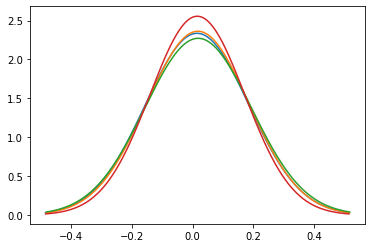

In [46]:
for i in train['qcut'].unique().tolist():
    mean = train[train['qcut'] == i].logerror.mean()
    std = train[train['qcut'] == i].logerror.std()
    x = np.linspace(mean-.5,mean+.5,1000)
    y = norm.pdf(x, loc=mean, scale=std)    # for example
    plt.plot(x,y, label = i)